# Music Genre Classification - Model Training

This notebook demonstrates the process of training a Convolutional Neural Network (CNN) for music genre classification using the GTZAN dataset.

## 1. Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

## 2. Configuration

In [2]:
# Dataset path
DATA_PATH = '../data/raw/GTZAN/genres_original'

# Audio parameters
SAMPLE_RATE = 22050
DURATION = 30  # seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION

# Spectrogram parameters
N_MELS = 128
N_FFT = 2048
HOP_LENGTH = 512

# Genre classes (GTZAN dataset)
GENRES = [
    'blues',
    'classical',
    'country',
    'disco',
    'hiphop',
    'jazz',
    'metal',
    'pop',
    'reggae',
    'rock'
]

## 3. Load and Process Data

In [3]:
def load_data(data_path):
    """
    Load audio files and generate spectrograms
    
    Args:
        data_path (str): Path to the dataset
        
    Returns:
        tuple: (spectrograms, labels)
    """
    spectrograms = []
    labels = []
    
    # Process each genre folder
    for genre_idx, genre in enumerate(GENRES):
        genre_path = os.path.join(data_path, genre)
        
        # Skip if folder doesn't exist
        if not os.path.exists(genre_path):
            print(f"Warning: {genre_path} does not exist. Skipping...")
            continue
        
        print(f"Processing {genre} files...")
        
        # Process each audio file in the genre folder
        for filename in os.listdir(genre_path):
            if not filename.endswith('.wav'):
                continue
                
            # Load audio file
            file_path = os.path.join(genre_path, filename)
            y, sr = librosa.load(file_path, sr=SAMPLE_RATE, mono=True)
            
            # Generate Mel spectrogram
            mel_spectrogram = librosa.feature.melspectrogram(
                y=y,
                sr=sr,
                n_fft=N_FFT,
                hop_length=HOP_LENGTH,
                n_mels=N_MELS
            )
            
            # Convert to dB scale
            mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
            
            # Add to dataset
            spectrograms.append(mel_spectrogram_db)
            labels.append(genre_idx)
    
    return np.array(spectrograms), np.array(labels)

In [4]:
# Load data
# Note: Using pre-processed spectrograms instead of processing raw audio files
# Comment out the following line if you want to process raw audio files instead
# spectrograms, labels = load_data(DATA_PATH)

# Load pre-processed spectrograms
print('Loading pre-processed spectrograms...')
# Check if spectrograms.npy exists in the directory
import os
spectrogram_files = []
for root, dirs, files in os.walk('../data/processed/spectrograms_npy'):
    for file in files:
        if file.endswith('.npy'):
            spectrogram_files.append(os.path.join(root, file))
            
print(f'Found {len(spectrogram_files)} .npy files')

# Load the first spectrogram file to get the shape
if len(spectrogram_files) > 0:
    sample_spec = np.load(spectrogram_files[0])
    print(f'Sample spectrogram shape: {sample_spec.shape}')

# Function to resize spectrograms to a fixed size
def resize_spectrogram(spec, target_length=1293):
    # If spectrogram is longer than target, truncate it
    if spec.shape[1] > target_length:
        return spec[:, :target_length]
    # If spectrogram is shorter than target, pad it with zeros
    elif spec.shape[1] < target_length:
        padding = np.zeros((spec.shape[0], target_length - spec.shape[1]))
        return np.hstack((spec, padding))
    else:
        return spec

# Load all spectrograms from individual files
spectrograms = []
labels = []

# Set a fixed length for all spectrograms (using the most common length)
TARGET_LENGTH = 1293  # This is based on the sample spectrogram shape

for genre_idx, genre in enumerate(GENRES):
    genre_path = os.path.join('../data/processed/spectrograms_npy', genre)
    if os.path.exists(genre_path):
        print(f'Loading {genre} spectrograms...')
        for file in os.listdir(genre_path):
            if file.endswith('.npy'):
                spec = np.load(os.path.join(genre_path, file))
                # Resize spectrogram to fixed length
                resized_spec = resize_spectrogram(spec, TARGET_LENGTH)
                spectrograms.append(resized_spec)
                labels.append(genre_idx)

spectrograms = np.array(spectrograms)
labels = np.array(labels)

print(f"Loaded {len(spectrograms)} spectrograms with shape {spectrograms[0].shape}")

Loading pre-processed spectrograms...
Found 999 .npy files
Sample spectrogram shape: (128, 1293)
Loading blues spectrograms...
Loading classical spectrograms...
Loading country spectrograms...
Loading disco spectrograms...
Loading hiphop spectrograms...
Loading jazz spectrograms...
Loading metal spectrograms...
Loading pop spectrograms...
Loading reggae spectrograms...
Loading rock spectrograms...
Loaded 999 spectrograms with shape (128, 1293)


## 4. Prepare Data for Training

In [5]:
# Add channel dimension for CNN
X = spectrograms[..., np.newaxis]

# Convert labels to one-hot encoding
y = to_categorical(labels, num_classes=len(GENRES))

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set: {X_train.shape}")
print(f"Testing set: {X_test.shape}")

Training set: (799, 128, 1293, 1)
Testing set: (200, 128, 1293, 1)


## 5. Build CNN Model

In [6]:
def build_model(input_shape):
    """
    Build a CNN model for music genre classification
    
    Args:
        input_shape (tuple): Shape of input data
        
    Returns:
        tf.keras.Model: Compiled model
    """
    model = models.Sequential([
        # First convolutional block
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),
        
        # Second convolutional block
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),
        
        # Third convolutional block
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),
        
        # Flatten and dense layers
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(len(GENRES), activation='softmax')
    ])
    
    # Compile model
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [7]:
# Build model
input_shape = X_train[0].shape
model = build_model(input_shape)

# Print model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 1293, 32)  │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 646, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 646, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 646, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 323, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 323, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 323, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 161, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 161, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 329728)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    84,410,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 84,506,762 (322.37 MB)

 Trainable params: 84,506,314 (322.37 MB)

 Non-trainable params: 448 (1.75 KB)

## 6. Train Model

In [8]:
# Define callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=2)
]

# Train model
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    callbacks=callbacks
)

Epoch 1/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 84s 4s/step - accuracy: 0.1997 - loss: 49.6263 - val_accuracy: 0.0938 - val_loss: 1802.4133 - learning_rate: 0.0010
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 83s 4s/step - accuracy: 0.2410 - loss: 2.7342 - val_accuracy: 0.1500 - val_loss: 841.7089 - learning_rate: 0.0010
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 88s 4s/step - accuracy: 0.1772 - loss: 2.3428 - val_accuracy: 0.1125 - val_loss: 330.1429 - learning_rate: 0.0010
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 90s 5s/step - accuracy: 0.1414 - loss: 2.2623 - val_accuracy: 0.1187 - val_loss: 98.8968 - learning_rate: 0.0010
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 105s 5s/step - accuracy: 0.1878 - loss: 2.3315 - val_accuracy: 0.1750 - val_loss: 33.6034 - learning_rate: 0.0010
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 111s 6s/step - accuracy: 0.1976 - loss: 2.1409 - val_accuracy: 0.1688 - val_loss: 12.1396 - learning_rate: 0.0010
Epoch 7/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 106s 5s/step - accuracy: 0.1835 - loss: 2.1707 - 

## 7. Evaluate Model

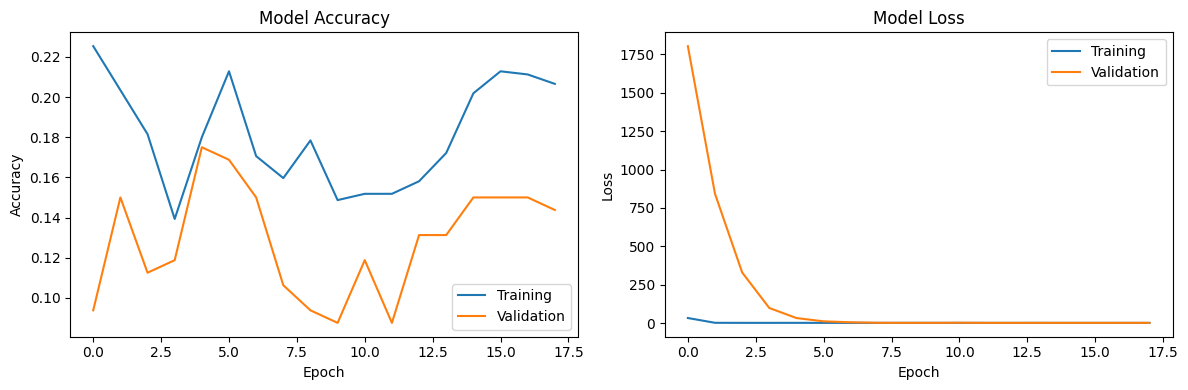

In [9]:
# Plot training history
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [10]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 576ms/step - accuracy: 0.1434 - loss: 2.2506
Test accuracy: 0.1700


## 8. Save Model

In [11]:
# Create model directory if it doesn't exist
model_dir = '../model'
os.makedirs(model_dir, exist_ok=True)

# Save model
model_path = os.path.join(model_dir, 'genre_classifier_model.h5')
model.save(model_path)
print(f"Model saved to {model_path}")

Model saved to ../model/genre_classifier_model.h5


## 9. Test Prediction

In [12]:
def predict_genre(model, spectrogram):
    """
    Predict genre from spectrogram
    
    Args:
        model (tf.keras.Model): Trained model
        spectrogram (numpy.ndarray): Mel spectrogram
        
    Returns:
        tuple: (predicted_genre, confidence_scores)
    """
    # Add batch and channel dimensions
    spectrogram = spectrogram.reshape(1, *spectrogram.shape, 1)
    
    # Make prediction
    prediction = model.predict(spectrogram)[0]
    
    # Get predicted genre and confidence
    predicted_index = np.argmax(prediction)
    predicted_genre = GENRES[predicted_index]
    confidence = prediction[predicted_index]
    
    # Get confidence scores for all genres
    confidence_scores = {genre: float(score) for genre, score in zip(GENRES, prediction)}
    
    return predicted_genre, confidence_scores

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
True genre: disco
Predicted genre: rock

Confidence scores:
rock: 0.1047
classical: 0.1014
disco: 0.1010
metal: 0.1006
hiphop: 0.1005
country: 0.1004
pop: 0.0996
blues: 0.0991
reggae: 0.0966
jazz: 0.0961


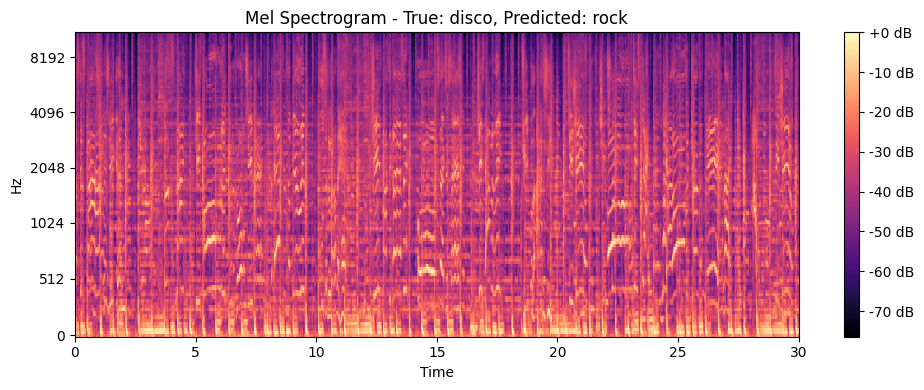

In [13]:
# Test prediction on a sample from the test set
sample_index = np.random.randint(0, len(X_test))
sample_spectrogram = X_test[sample_index, :, :, 0]  # Remove channel dimension
true_genre = GENRES[np.argmax(y_test[sample_index])]

# Predict genre
predicted_genre, confidence_scores = predict_genre(model, sample_spectrogram)

print(f"True genre: {true_genre}")
print(f"Predicted genre: {predicted_genre}")
print("\nConfidence scores:")
for genre, score in sorted(confidence_scores.items(), key=lambda x: x[1], reverse=True):
    print(f"{genre}: {score:.4f}")

# Plot spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(
    sample_spectrogram,
    sr=SAMPLE_RATE,
    hop_length=HOP_LENGTH,
    x_axis='time',
    y_axis='mel'
)
plt.colorbar(format='%+2.0f dB')
plt.title(f"Mel Spectrogram - True: {true_genre}, Predicted: {predicted_genre}")
plt.tight_layout()
plt.show()